<a href="https://colab.research.google.com/github/jman4162/Engineering-System-Optimization-MDAO-/blob/main/Optimizing_a_Cantilever_Beam_Design_with_OpenMDAO_A_Step_by_Step_Python_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing a Cantilever Beam Design with OpenMDAO: A Step-by-Step Python Tutorial

Name: John Hodge

Date: 04/21/24

OpenMDAO is an open-source high-performance computing platform for systems analysis and multidisciplinary optimization, developed by NASA. It is particularly well-suited for solving complex engineering problems involving multiple disciplines. In this tutorial, we will go through a basic example of how to use [OpenMDAO](https://openmdao.org/) to optimize an engineering system design. Specifically, we will focus on optimizing the design of a simple cantilever beam to minimize its mass under constraints on its maximum displacement when a load is applied at the end.

## Step 1: Define the Problem

For our example, the cantilever beam is defined by its length ($L$), width ($b$), and height ($h$). The goal is to minimize the mass of the beam, which is directly proportional to its volume (assuming constant material density), subject to constraints on its maximum displacement under a given load.

The mass of the beam can be calculated as:

$ \text{Mass} = \rho \times L \times b \times h $

where \( $\rho$ \) is the material density (constant).

The displacement ( $d$ ) at the free end of the beam under a load \( $P$ \) can be approximated by:

$ d = \frac{4 \times P \times L^3}{E \times b \times h^3} $

where \($E$\) is the modulus of elasticity (constant).

## Initialize Environment and Import Libraries

In [236]:
!pip install openmdao matplotlib numpy

In [237]:
import openmdao.api as om
import matplotlib.pyplot as plt
import numpy as np

## Define Engineering System Components

In [238]:
class BeamMass(om.ExplicitComponent):
    def setup(self):
        # Inputs
        self.add_input('rho', val=7850)  # Material density
        self.add_input('L', val=2.0)    # Length
        self.add_input('b', val=5.0)    # Width
        self.add_input('h', val=5.0)    # Height

        # Outputs
        self.add_output('mass', val=0.0)

        # Partial derivatives
        self.declare_partials(of='mass', wrt='b')
        self.declare_partials(of='mass', wrt='h')

    def compute(self, inputs, outputs):
        rho = inputs['rho']
        L = inputs['L']
        b = inputs['b']
        h = inputs['h']
        outputs['mass'] = rho * L * b * h

    def compute_partials(self, inputs, partials):
        rho = inputs['rho']
        L = inputs['L']
        b = inputs['b']
        h = inputs['h']
        partials['mass', 'b'] = rho * L * h
        partials['mass', 'h'] = rho * L * b


## Define the Constraint


In [239]:
# Adding a scaling factor for numerical reasons
scale_fac = 1e12

In [240]:
class BeamDisplacement(om.ExplicitComponent):
    def setup(self):
        # Inputs
        self.add_input('P', val=1000)    # Applied load
        self.add_input('L', val=2.0)    # Length
        self.add_input('b', val=5.0)    # Width
        self.add_input('h', val=5.0)    # Height
        self.add_input('E', val=2.1e11)    # Modulus of elasticity

        # Outputs
        self.add_output('disp', val=0.0)

        # Partial derivatives
        self.declare_partials(of='disp', wrt=['b', 'h'])

    def compute(self, inputs, outputs):
        P = inputs['P']
        L = inputs['L']
        b = inputs['b']
        h = inputs['h']
        E = inputs['E']
        outputs['disp'] = (4 * P * L**3) / (E * b * h**3) * scale_fac

    def compute_partials(self, inputs, partials):
        P = inputs['P']
        L = inputs['L']
        b = inputs['b']
        h = inputs['h']
        E = inputs['E']
        partials['disp', 'b'] = - (4 * P * L**3) / (E * b**2 * h**3) * scale_fac
        partials['disp', 'h'] = -3 * (4 * P * L**3) / (E * b * h**4) * scale_fac


## Setup the Optimization Problem


In [241]:
# Create a problem and model
prob = om.Problem()
model = prob.model

# Add components
model.add_subsystem('comp', BeamMass(), promotes=['b', 'h'])
model.add_subsystem('disp', BeamDisplacement(), promotes=['b', 'h'])

# Setup the optimizer
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'
prob.driver.options['tol'] = 1e-9
prob.driver.options['disp'] = True
prob.driver.options['maxiter'] = 1000

print(prob.driver.options)

=======================  =======  =======================  ================  =======================
Option                   Default  Acceptable Values        Acceptable Types  Description            
=======================  =======  =======================  ================  =======================
debug_print              []       ['desvars', 'nl_cons',   ['list']          List of what type of   
                                  'ln_cons', 'objs',                         Driver variables to    
                                  'totals']                                  print at each          
                                                                             iteration.             
disp                     True     [True, False]            ['bool']          Set to False to prevent
                                                                             printing of Scipy      
                                                                             convergence me

## Define the Design Variables, Objective, and Constraints


In [242]:
# Design variables
model.add_design_var('b', lower=1.0, upper=10.0)
model.add_design_var('h', lower=1.0, upper=10.0)

# Objective
model.add_objective('comp.mass')

# Constraints
max_disp = 200
model.add_constraint('disp.disp', upper=max_disp) # Limit maximum displacement


## Setup Problem and Define Constants

In [243]:
# Set constant values
model.set_input_defaults('comp.rho', 7850)  # density of steel in kg/m^3
model.set_input_defaults('comp.L', 2.0)     # length of the beam in meters
model.set_input_defaults('disp.P', 1000)    # load in newtons
model.set_input_defaults('disp.E', 2.1e11)  # modulus of elasticity of steel in Pascals

# Setup the problem
prob.setup()

In [244]:
# Get and print initial values
b_init = prob.get_val('disp.b')
h_init = prob.get_val('disp.h')

(b_init, h_init)

(array([5.]), array([5.]))

In [245]:
# Investigate the initial values
print("Initial width  (b): {:.2f} m".format(b_init[0]))
print("Initial height (h): {:.2f} m".format(h_init[0]))

Initial width  (b): 5.00 m
Initial height (h): 5.00 m


### View outputs of initial system parameters

In [246]:
# Run the model to compute initial outputs
prob.run_model()

# Get initial mass and displacement
initial_mass = prob.get_val('comp.mass')
initial_disp = prob.get_val('disp.disp')

# Output the initial values
print("Initial Mass:", initial_mass, "kg")
print("Initial Displacement:", initial_disp, "meters")

Initial Mass: [392500.] kg
Initial Displacement: [243.80952381] meters


In [247]:
(b_init, h_init, initial_mass, initial_disp)

(array([5.]), array([5.]), array([392500.]), array([243.80952381]))

In [248]:
# Make a copy of initial_mass and initial_disp
initial_mass_copy = initial_mass.copy()
initial_disp_copy = initial_disp.copy()

## Run the Optimization

In [249]:
# Run the optimizer
prob.run_driver()

# Run the model to compute values
prob.run_model()

# Get and print results
b_opt = prob.get_val('disp.b')
h_opt = prob.get_val('disp.h')
mass_opt = prob.get_val('comp.mass')
disp_opt = prob.get_val('disp.disp')

print("Optimized width (b): {:.2f} m".format(b_opt[0]))
print("Optimized height (h): {:.2f} m".format(h_opt[0]))
print("Optimized mass: {:.2f} kg".format(mass_opt[0]))
print("Resulting displacement: {:.4e} m".format(disp_opt[0]))

print('mass_opt:', mass_opt)
print('disp_opt:', disp_opt)

(b_opt, h_opt, mass_opt, disp_opt)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 143673.59340666395
            Iterations: 11
            Function evaluations: 7
            Gradient evaluations: 7
Optimization Complete
-----------------------------------
Optimized width (b): 1.00 m
Optimized height (h): 9.15 m
Optimized mass: 143673.59 kg
Resulting displacement: 1.9884e+02 m
mass_opt: [143673.59340666]
disp_opt: [198.83772194]


(array([1.]),
 array([9.15118429]),
 array([143673.59340666]),
 array([198.83772194]))

## Analyze results

<ipython-input-250-2416891d5e19>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b_init = float(b_init)
<ipython-input-250-2416891d5e19>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h_init = float(h_init)
<ipython-input-250-2416891d5e19>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  initial_mass = float(initial_mass_copy)
<ipython-input-250-2416891d5e19>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in

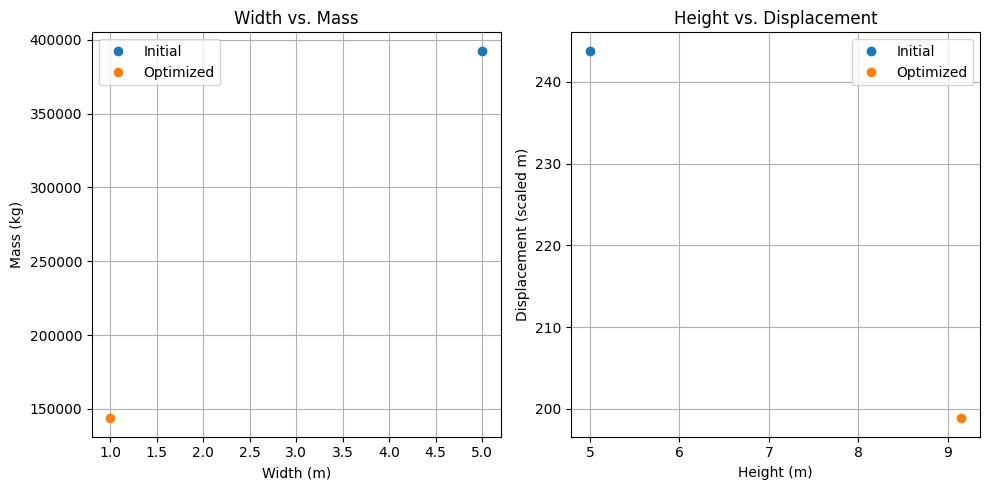

In [250]:
# Values - assuming these are arrays of data points; for a single run, you can use lists of single values
b_init = float(b_init)
h_init = float(h_init)
initial_mass = float(initial_mass_copy)
initial_disp = float(initial_disp)

b_values = [b_init, b_opt]  # Example values from lower bound to optimized
h_values = [h_init, h_opt]  # Example values from lower bound to optimized
mass_values = [initial_mass, mass_opt]  # Initial and optimized masses
disp_values = [initial_disp, disp_opt]  # Initial and optimized displacements

# Plot width vs. mass
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(b_init, initial_mass_copy[0], 'o', label='Initial')
plt.plot(b_opt[0], mass_opt[0], 'o', label='Optimized')
plt.title('Width vs. Mass')
plt.xlabel('Width (m)')
plt.ylabel('Mass (kg)')
plt.grid(True)
plt.legend(loc='best')

# Plot height vs. displacement
plt.subplot(1, 2, 2)
plt.plot(h_init, initial_disp_copy[0], 'o', label='Initial')
plt.plot(h_opt[0], disp_opt[0], 'o', label='Optimized')
plt.title('Height vs. Displacement')
plt.xlabel('Height (m)')
plt.ylabel('Displacement (scaled m)')
plt.grid(True)
plt.legend(loc='best')

plt.tight_layout()
plt.show()

## Simulated data based on the optimization scenario

In [251]:
# Assuming material properties and initial settings
rho = 7850  # density of steel in kg/m^3
L = 2.0  # length of the beam in meters
P = 1000  # load in newtons
E = 2.1e11  # modulus of elasticity of steel in Pascals

# Simulated optimized values (normally obtained from optimization results)
# b_opt = b_opt[0]  # optimized width in meters
# h_opt = h_opt[0]  # optimized height in meters
mass_opt = rho * L * b_opt[0] * h_opt[0]  # optimized mass
disp_opt = (4 * P * L**3) / (E * b_opt[0] * h_opt[0]**3) * scale_fac # optimized displacement

# Simulated ranges for width and height from initial to optimized
b_values = np.linspace(0.1, 10, 50)
h_values = np.linspace(0.1, 10, 50)
mass_values = rho * L * b_values * h_opt[0]
disp_values = (4 * P * L**3) / (E * b_values * h_opt[0]**3) * scale_fac

(h_opt[0], h_opt[0])

(9.151184293418085, 9.151184293418085)

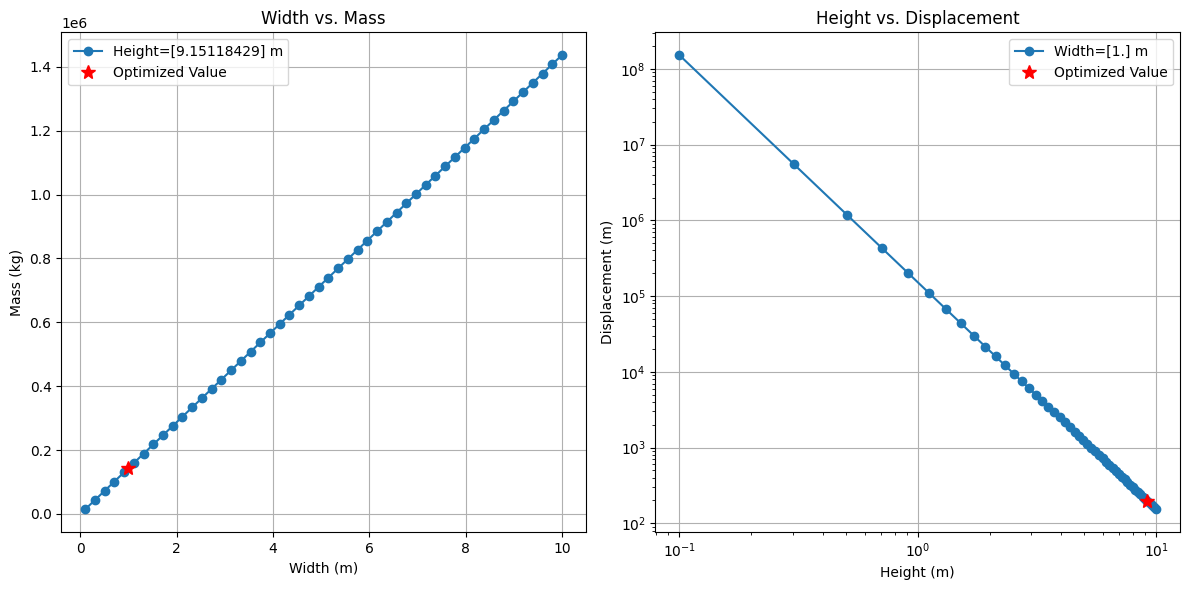

In [252]:
# Plot width vs. mass
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(b_values, mass_values, 'o-', label=f'Height={h_opt} m')
plt.plot(b_opt, mass_opt, 'r*', label='Optimized Value', markersize=10)
plt.title('Width vs. Mass')
plt.xlabel('Width (m)')
plt.ylabel('Mass (kg)')
plt.grid(True)
plt.legend()

# Plot height vs. displacement
plt.subplot(1, 2, 2)
plt.loglog(h_values, (4 * P * L**3) / (E * b_opt[0] * h_values**3) * scale_fac, 'o-', label=f'Width={b_opt} m')
plt.loglog(h_opt, disp_opt, 'r*', label='Optimized Value', markersize=10)
plt.title('Height vs. Displacement')
plt.xlabel('Height (m)')
plt.ylabel('Displacement (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Conclusion

This basic example demonstrates the use of OpenMDAO for solving a simple structural optimization problem. In practice, OpenMDAO can be used for much more complex systems and analyses, including aerospace applications, vehicle design, and much more.

In a real-world application, you would typically refine the problem by including more detailed models of the physics involved, possibly dynamic behaviors, other disciplines like heat transfer or fluid dynamics, and you might utilize gradient-enhanced optimization techniques provided by OpenMDAO's advanced capabilities.

This tutorial provides a foundation that can be expanded upon to tackle more complex and multidisciplinary engineering optimization problems.

Here are the plots generated based on the simulated optimization results for a cantilever beam:

1. **Width vs. Mass**: This plot shows the relationship between the width of the beam and its mass, holding height constant at the optimized value. As expected, the mass increases linearly with the width because the volume (and thus mass) of the beam is directly proportional to its width.

2. **Height vs. Displacement**: This plot illustrates how displacement at the end of the beam decreases as the height increases, with width held constant at the optimized value. The displacement decreases sharply as height increases due to its cubic relationship in the beam’s bending equation.

These plots help visualize the trade-offs and impacts of different design variables on the system's objectives and constraints. If you have specific results from an actual OpenMDAO run, similar plots can be generated to analyze those results in detail.

# Appendix

## Example openMDAO Usage

In [253]:
# build the model
prob = om.Problem()

prob.model.add_subsystem('paraboloid', om.ExecComp('f = (x-3)**2 + x*y + (y+4)**2 - 3'))

# setup the optimization
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'

prob.model.add_design_var('paraboloid.x', lower=-50, upper=50)
prob.model.add_design_var('paraboloid.y', lower=-50, upper=50)
prob.model.add_objective('paraboloid.f')

prob.setup()

# set initial values
prob.set_val('paraboloid.x', 3.0)
prob.set_val('paraboloid.y', -4.0)

# run the optimization
prob.run_driver()

# minimum value
print('paraboloid.f:', prob.get_val('paraboloid.f'))

# location of the minimum
print('paraboloid.x:', prob.get_val('paraboloid.x'))
print('paraboloid.y:', prob.get_val('paraboloid.y'))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -27.33333333333333
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 5
Optimization Complete
-----------------------------------
paraboloid.f: [-27.33333333]
paraboloid.x: [6.66666667]
paraboloid.y: [-7.33333333]


# Simpler Cantilever Beam Design Example Using openMDAO

In [254]:
# Optimizing a Cantilever Beam Design with OpenMDAO: A Step-by-Step Python Tutorial

# Define constants
E = 200e9  # Modulus of elasticity (Pa)
P = 50e3   # Applied load (N)
rho = 7800 # Material density (kg/m^3)
max_displacement = 0.01  # Maximum allowable displacement (m)

class BeamDesign(om.ExplicitComponent):
   """
   Define the cantilever beam design problem using OpenMDAO.
   """

   def setup(self):
       # Define design variables
       self.add_input('beam_length', val=5.0, desc='Beam length (m)')
       self.add_input('beam_width', val=0.1, desc='Beam width (m)')
       self.add_input('beam_height', val=0.2, desc='Beam height (m)')

       # Define outputs
       self.add_output('mass', val=0.0, desc='Beam mass (kg)')
       self.add_output('displacement', val=0.0, desc='Beam end displacement (m)')

       # Specify partial derivative calculation method
       self.declare_partials('*', '*', method='fd')

   def compute(self, inputs, outputs):
       # Compute the mass and displacement of the beam
       L = inputs['beam_length']
       b = inputs['beam_width']
       h = inputs['beam_height']

       outputs['mass'] = rho * L * b * h
       outputs['displacement'] = (4 * P * L**3) / (E * b * h**3)

# Create the design problem
prob = om.Problem()
model = prob.model

# Add the design component to the model
model.add_subsystem('beam', BeamDesign(), promotes=['*'])

# Set up the design optimization problem
model.add_design_var('beam_length', lower=1.0, upper=10.0)
model.add_design_var('beam_width', lower=0.05, upper=1.0)
model.add_design_var('beam_height', lower=0.05, upper=1.0)

# Define the objective function and constraints
model.add_objective('mass')
model.add_constraint('displacement', upper=max_displacement)

# Set up the optimization driver
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'
prob.driver.options['disp'] = True

prob.setup()

# Set initial values for the design variables
prob.set_val('beam_length', 5.0)
prob.set_val('beam_width', 0.1)
prob.set_val('beam_height', 0.2)

# Run the optimization
prob.run_driver()

# Print the optimized design
print(f"Optimized beam design:")
print(f"  Length: {prob.get_val('beam_length')[0]:.4f} m")
print(f"  Width: {prob.get_val('beam_width')[0]:.4f} m")
print(f"  Height: {prob.get_val('beam_height')[0]:.4f} m")
print(f"  Mass: {prob.get_val('mass')[0]:.4f} kg")
print(f"  Displacement: {prob.get_val('displacement')[0]:.6f} m")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 49.13691125414173
            Iterations: 5
            Function evaluations: 16
            Gradient evaluations: 5
Optimization Complete
-----------------------------------
Optimized beam design:
  Length: 1.0000 m
  Width: 0.0500 m
  Height: 0.1260 m
  Mass: 49.1369 kg
  Displacement: 0.010000 m
